https://www.youtube.com/watch?v=w8yWXqWQYmU&ab_channel=SamsonZhang

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('train.csv')

In [3]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Each row is and example.

In [4]:
# convert the pandas dataframe to a numpy array so we can perform matrix operations
data = data.to_numpy()
print('Train: ',data.shape)

Train:  (42000, 785)


In [5]:
m, n = data.shape
# shuffle the data so we can split it into train and validation sets
np.random.shuffle(data)
# split the data into train and validation sets
train_set = data[:30000].T # select the first 30,000 rows and transpose the data so that columns are rows(examples)
y_train = train_set[0] # first column is the label
X_train = train_set[1:n] # rest of the columns are the features
# the pixel values are between 0 and 255, we normalize them to be between 0 and 1
X_train = X_train / 255.0

# validation data
val_set = data[30000:m].T # validation data and we transpose the data
y_val = val_set[0] # first column is the label
X_val = val_set[1:n] # rest of the columns are the features
X_val = X_val / 255.0 # normalize the data

In [6]:
print('X_train data', X_train.shape)
print('X_val data', X_val.shape)

X_train data (784, 30000)
X_val data (784, 12000)


In [7]:
y_train.shape

(30000,)

In [8]:
y_val

array([5, 1, 9, ..., 1, 1, 1], shape=(12000,))

In [9]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(784, 30000))

In [10]:
np.random.rand(5, 3) - 0.5

array([[-6.81975309e-02,  4.39236786e-01, -6.62204309e-02],
       [ 8.50508435e-02, -4.93593485e-01, -4.36247958e-01],
       [ 3.26507497e-01, -2.85440599e-01, -1.07087145e-06],
       [-4.75176937e-01, -1.17003212e-01, -4.38831789e-01],
       [-4.83224604e-01,  1.19491051e-01,  4.86368665e-01]])

In [11]:
def init_params():
    '''Function to initialise the model parameters'''
    W1 = np.random.rand(10, 784) - 0.5 # weight matrix for hidden layer
    b1 = np.random.rand(10, 1) - 0.5 # bias for hidden layer
    W2 = np.random.rand(10, 10) - 0.5 # weight matrix for output layer
    b2 = np.random.rand(10, 1) - 0.5 #  bias for output layer
    return W1, b1, W2, b2

def ReLU(Z):
    '''ReLU activation function
    This is an elementwise operation so it goes
    through each element of Z and applies the ReLU function'''
    return np.maximum(0, Z)

def softmax(Z):
    '''Softmax activation function'''
    expZ = np.exp(Z - np.max(Z)) # subtracting the max for numerical stability
    return expZ / expZ.sum(axis=0, keepdims=True) # return softmax of Z

def forward_prop(W1, b1, W2, b2, X):
    '''Function to perform forward propagation'''
    Z1 = W1.dot(X) + b1 # linear activation for hidden layer, 784 x m
    A1 = ReLU(Z1) # non-linear activation for hidden layer
    Z2 = W2.dot(A1) + b2 # linear activation for output layer
    A2 = softmax(Z2) # non-linear activation for output layer
    return Z1, A1, Z2, A2 # return all the activations and linear combinations

def one_hot_encoding(y):
    '''Function to perform one hot encoding'''
    m = y.shape[0] # number of examples
    y_onehot = np.zeros((10, m)) # one hot encoding of y
    for i in range(m):
        y_onehot[y[i], i] = 1 # set the correct class to 1
    return y_onehot

def back_prop(Z1, A1, Z2, A2, W2, X, Y):
    '''Function to perform backpropagation'''
    m = Y.size # number of examples
    one_hot_y = one_hot_encoding(Y) # one hot encode the labels
    dZ2 = A2 - one_hot_y # derivative of loss with respect to Z2
    dW2 = (1/m) * dZ2.dot(A1.T) # derivative of loss with respect to W2
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True) # derivative of loss with respect to b2

    dA1 = W2.T.dot(dZ2) # derivative of loss with respect to A1
    dZ1 = dA1 * (Z1 > 0) # derivative of loss with respect to Z1. Z1 > 0 is an elegant derivative of ReLU
    dW1 = (1/m) * dZ1.dot(X.T) # derivative of loss with respect to W1
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True) # derivative of loss with respect to b1

    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    '''Function to update the model parameters using gradient descent'''
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    return W1, b1, W2, b2

In [12]:
def get_predictions(A2):
    '''Function to get the predictions from the output of the network'''
    return np.argmax(A2, axis=0) # return the index of the max element in each column

def get_accuracy(predictions, Y):
    '''Function to get the accuracy of the model'''
    return np.sum(predictions == Y) / Y.size # return the accuracy

def gradient_descent(X, Y, epochs, learning_rate): # epochs are the number of iterations
    '''Function to perform gradient descent'''
    W1, b1, W2, b2 = init_params() # initialise the model parameters
    for i in range(epochs):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X) # forward propagation
        dW1, db1, dW2, db2 = back_prop(Z1, A1, Z2, A2, W2, X, Y) # backpropagation
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate) # update the model parameters
        if i % 10 == 0:
            print('Epoch %d' % i)
            predictions = get_predictions(A2) # get the predictions
            print('Accuracy: %.2f' % get_accuracy(predictions, Y)) # print the accuracy
    return W1, b1, W2, b2

In [13]:
W1, b1, W2, b2 = gradient_descent(X_val, y_val, 1000, 0.5)

Epoch 0
Accuracy: 0.11
Epoch 10
Accuracy: 0.44
Epoch 20
Accuracy: 0.58
Epoch 30
Accuracy: 0.68
Epoch 40
Accuracy: 0.70
Epoch 50
Accuracy: 0.72
Epoch 60
Accuracy: 0.75
Epoch 70
Accuracy: 0.77
Epoch 80
Accuracy: 0.79
Epoch 90
Accuracy: 0.80
Epoch 100
Accuracy: 0.82
Epoch 110
Accuracy: 0.83
Epoch 120
Accuracy: 0.84
Epoch 130
Accuracy: 0.84
Epoch 140
Accuracy: 0.85
Epoch 150
Accuracy: 0.86
Epoch 160
Accuracy: 0.86
Epoch 170
Accuracy: 0.86
Epoch 180
Accuracy: 0.87
Epoch 190
Accuracy: 0.87
Epoch 200
Accuracy: 0.87
Epoch 210
Accuracy: 0.88
Epoch 220
Accuracy: 0.88
Epoch 230
Accuracy: 0.88
Epoch 240
Accuracy: 0.88
Epoch 250
Accuracy: 0.88
Epoch 260
Accuracy: 0.89
Epoch 270
Accuracy: 0.89
Epoch 280
Accuracy: 0.89
Epoch 290
Accuracy: 0.89
Epoch 300
Accuracy: 0.89
Epoch 310
Accuracy: 0.89
Epoch 320
Accuracy: 0.90
Epoch 330
Accuracy: 0.90
Epoch 340
Accuracy: 0.90
Epoch 350
Accuracy: 0.90
Epoch 360
Accuracy: 0.90
Epoch 370
Accuracy: 0.90
Epoch 380
Accuracy: 0.90
Epoch 390
Accuracy: 0.90
Epoch 400
A

We get a 92% accuracy on the validation set with a single layer neural network, running 500 iterations at a learning rate of 0.5. This is pretty good. Next we shall try increasing the number of layers. But first, let us look at some of the images and their predictions.

In [14]:
print(W1, b1, W2, b2)

[[ 0.03442538  0.3266777   0.10334644 ... -0.01025249 -0.28479712
   0.04244506]
 [ 0.24775593 -0.22376879 -0.11409981 ...  0.39255645 -0.35917588
  -0.0461463 ]
 [-0.10571341  0.358455   -0.37603377 ... -0.43258932  0.33592469
  -0.01711399]
 ...
 [ 0.43758118  0.27704776  0.38630098 ... -0.0134234   0.28881124
  -0.19379876]
 [-0.09612017 -0.21687833  0.44233645 ... -0.4236537  -0.15160576
  -0.05096176]
 [-0.22610516 -0.34624704 -0.44498095 ...  0.36734578  0.45152516
   0.16499381]] [[-0.11700165]
 [-0.30890307]
 [ 0.14998303]
 [-0.87500321]
 [ 0.49845017]
 [ 0.75124607]
 [ 0.29935685]
 [ 0.02393559]
 [-0.0600526 ]
 [ 1.03380696]] [[ 0.41968737  0.7183301  -1.61502044 -0.07009371  0.06218222  0.69388403
   0.84176209  0.2526656  -0.43620687 -0.58650309]
 [-0.26883694 -0.05369919  1.40321984 -0.18148954 -0.48175167  0.10701603
   0.17879984 -1.00420683  0.4637636  -0.86369882]
 [-1.62280172 -0.27504959 -0.12688343 -0.01951057  0.31135166 -0.03714936
  -0.16391346  0.75930433  1.0699

In [15]:
def make_predictions(X, W1, b1, W2, b2):
    '''Function to make predictions on new data'''
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X) # forward propagation
    predictions = get_predictions(A2) # get the predictions
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    '''Function to test the predictions'''
    current_image = X_val[:, index, None]
    prediction = make_predictions(X_val[:, index, None], W1, b1, W2, b2)
    label = y_val[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [5]
Label:  5


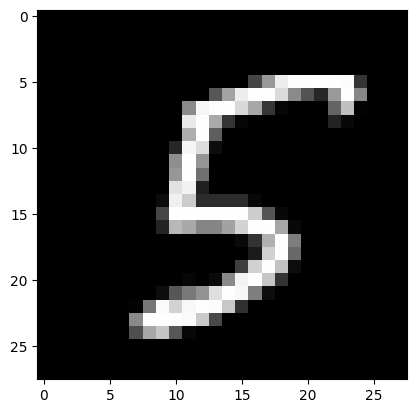

Prediction:  [1]
Label:  1


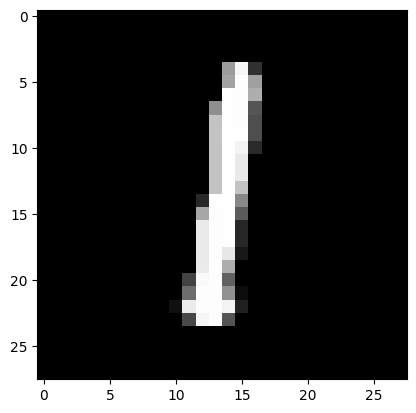

Prediction:  [9]
Label:  9


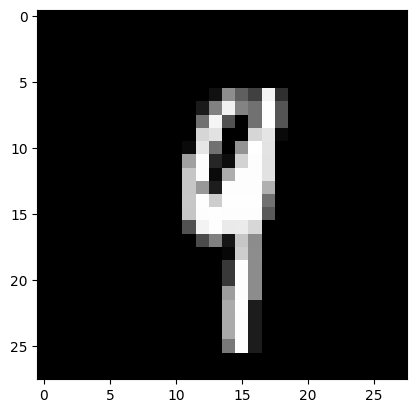

Prediction:  [2]
Label:  2


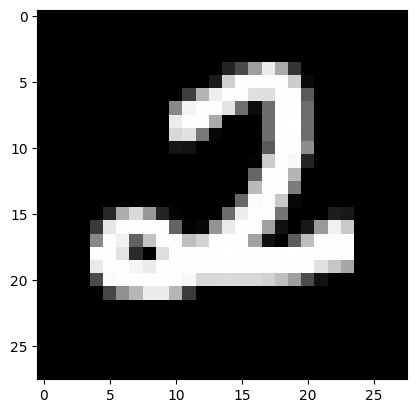

Prediction:  [9]
Label:  9


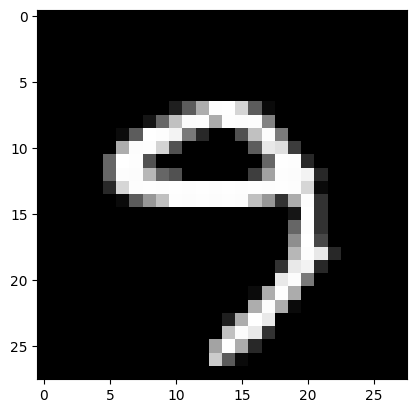

Prediction:  [8]
Label:  8


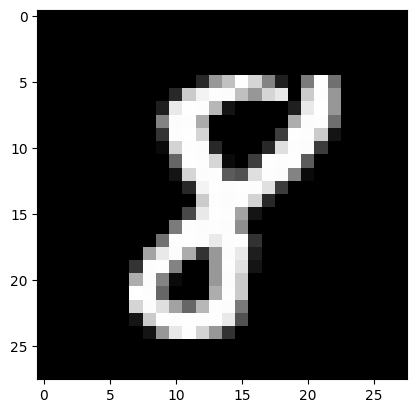

Prediction:  [2]
Label:  2


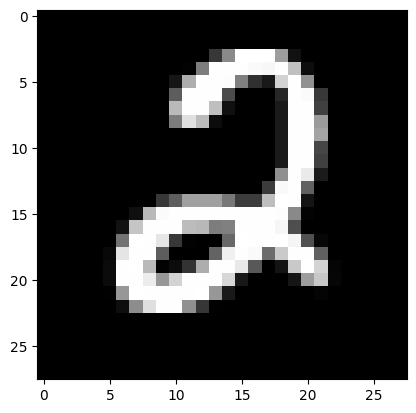

Prediction:  [1]
Label:  1


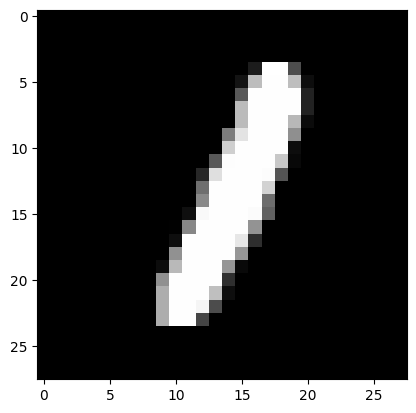

In [16]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)
test_prediction(52, W1, b1, W2, b2)
test_prediction(6, W1, b1, W2, b2)
test_prediction(28, W1, b1, W2, b2)
test_prediction(39, W1, b1, W2, b2)

The model does pretty well on data it has not seen. I shall extend this with more layers and an optimiser to see if it improves.